In [1]:
import functools
import numpy as np
import jax
from brax import envs
from brax.io import model, html
from brax.training.agents.apg import networks as apg_networks
from brax.training.acme import running_statistics
from diffmimic.mimic_envs import register_mimic_env
from IPython.display import HTML, clear_output
import matplotlib.pyplot as plt

In [2]:
# env
register_mimic_env()

f = '/data/benny_cai/diffmimic/humanoid_logs/exp_300_32_0.0003_1000_0.4_0_humanoid_threshold_0.4_True_54_30_54_True_0.02_0.5_0.01_0.01_backflip_fps_30_20s/eval_traj_best.npy'
rollout_traj = np.load(f)

if len(rollout_traj.shape) == 3:
    seed = 0
    rollout_traj = rollout_traj[:, seed]

env = envs.get_environment(
    env_name="humanoid_mimic",
    system_config='humanoid',
    reference_traj=rollout_traj,
)

In [3]:
# network
network_factory = functools.partial(apg_networks.make_apg_networks, hidden_layer_sizes=(512, 256))
normalize = running_statistics.normalize
apg_network = network_factory(
      env.observation_size,
      env.action_size,
      preprocess_observations_fn=normalize)

# policy
make_policy = apg_networks.make_inference_fn(apg_network)
params = model.load_params('/data/benny_cai/diffmimic/humanoid_logs/exp_300_32_0.0003_1000_0.4_0_humanoid_threshold_0.4_True_54_30_54_True_0.02_0.5_0.01_0.01_backflip_fps_30_20s/params_best.pkl')
policy = make_policy(params)

In [4]:
# Visualizing a trajectory of the learned inference function
jit_env_reset = jax.jit(env.reset) # reset: retrieve the 1st state from the reference motion
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(policy)

rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)
act_list = []
for i in range(54):
    print("###########", i)
    rollout.append(state.qp)
    act_rng, rng = jax.random.split(rng)
    act, _ = jit_inference_fn(state.obs, act_rng)
    act_list.append(act)
    # print("action: ", act)
    state = jit_env_step(state, act)

########### 0
target_angles: [-0.02530874  0.67939246 -0.47891584]
target_angles: [-0.02530874  0.67939246 -0.47891584]
target_angles: [ 0.37578085 -0.18884018 -0.49241787]
target_angles: [ 0.37578085 -0.18884018 -0.49241787]
target_angles: [-1.97348     0.48802507  0.1042216 ]
target_angles: [-1.97348     0.48802507  0.1042216 ]
target_angles: [-0.11469974 -0.         -0.        ]
target_angles: [-0.11469974 -0.         -0.        ]
target_angles: [ 1.9762585   0.7383369  -0.93887115]
target_angles: [ 1.9762585   0.7383369  -0.93887115]
target_angles: [ 0.24225876 -0.         -0.        ]
target_angles: [ 0.24225876 -0.         -0.        ]
target_angles: [ 0.42910448 -1.3933333   0.03970787]
target_angles: [ 0.42910448 -1.3933333   0.03970787]
target_angles: [ 0.9133352 -0.        -0.       ]
target_angles: [ 0.9133352 -0.        -0.       ]
target_angles: [-0.27385104  0.9176314   0.10207056]
target_angles: [-0.27385104  0.9176314   0.10207056]
target_angles: [-0.3897433  -0.9988601

In [7]:
HTML(html.render(env.sys, rollout))

In [10]:
act_list = np.array(act_list)
act_list.shape

(54, 28)

In [24]:
components = [
    'abdomen_x', 'abdomen_y', 'abdomen_z',
    'neck_x', 'neck_y', 'neck_z',
    'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'right_elbow',
    'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'left_elbow',
    'right_hip_x', 'right_hip_z', 'right_hip_y', 'right_knee',
    'right_ankle_x', 'right_ankle_y', 'right_ankle_z',
    'left_hip_x', 'left_hip_z', 'left_hip_y', 'left_knee',
    'left_ankle_x', 'left_ankle_y', 'left_ankle_z'
]

/tmp/ipykernel_3235998/1774124435.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(4, 3))


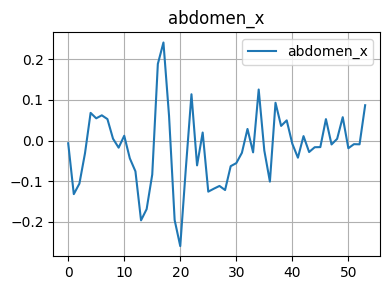

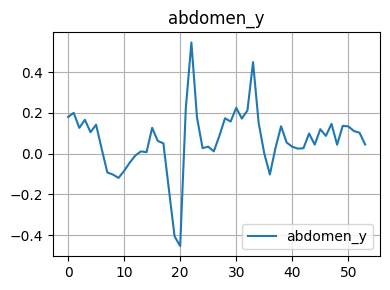

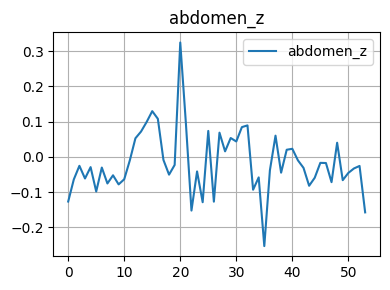

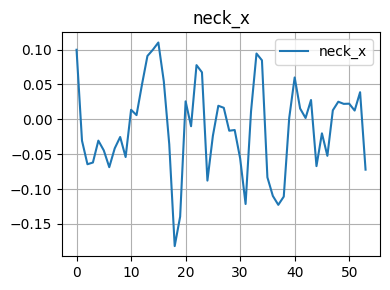

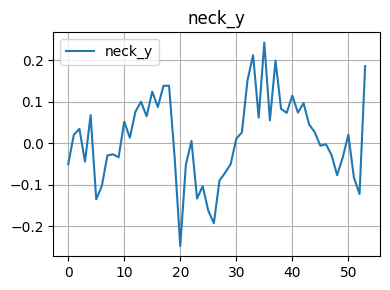

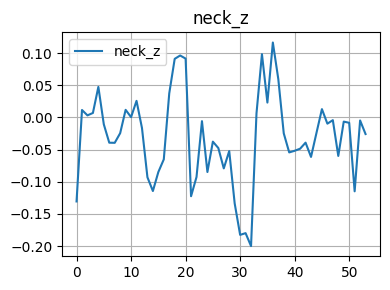

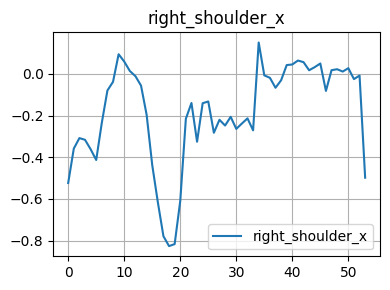

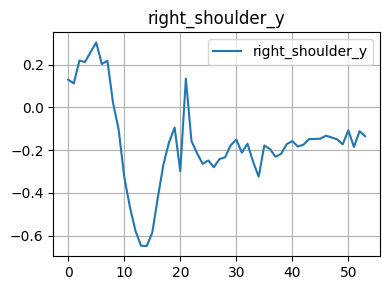

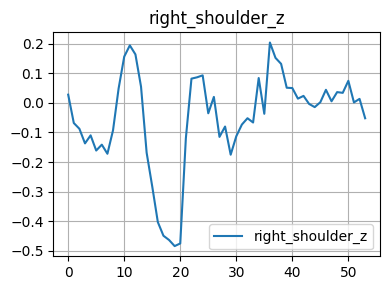

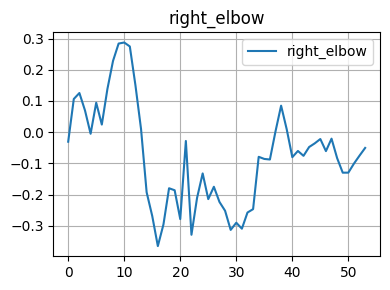

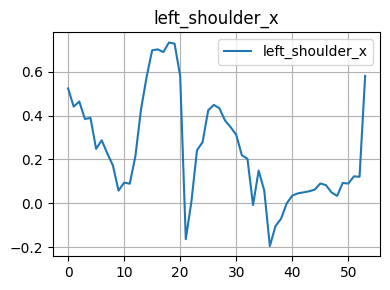

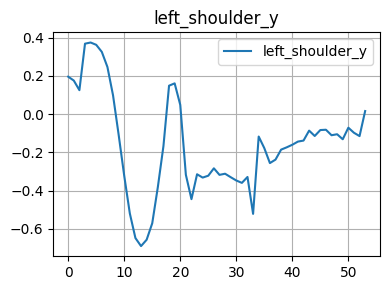

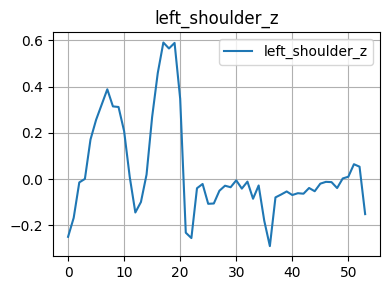

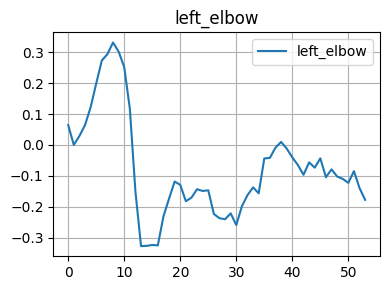

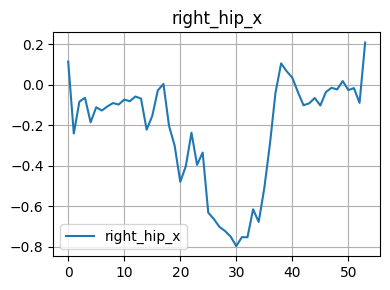

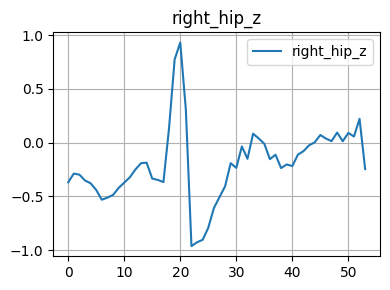

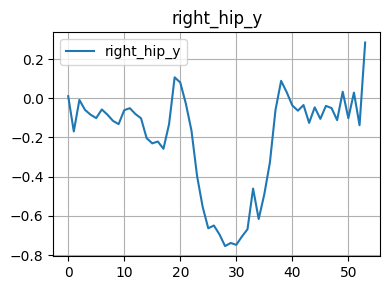

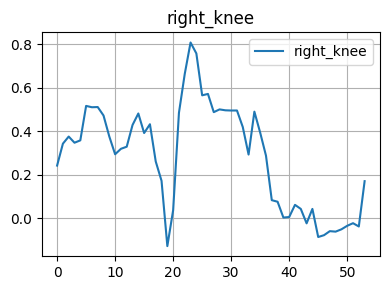

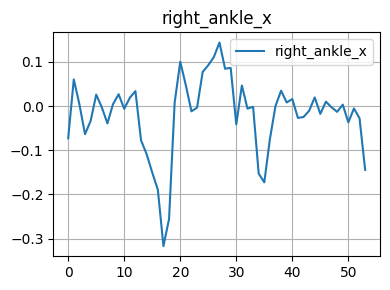

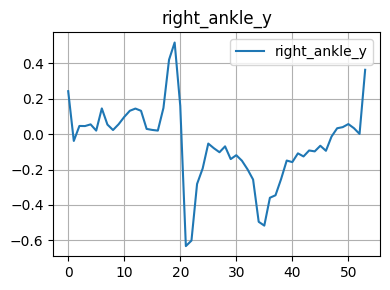

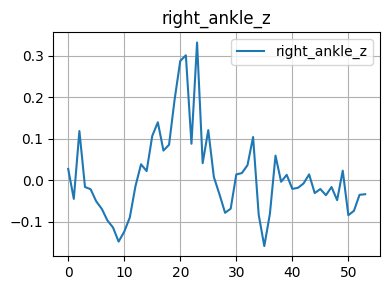

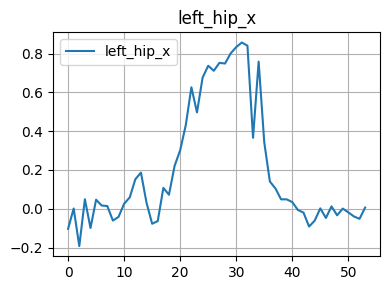

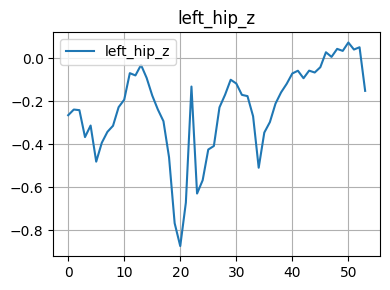

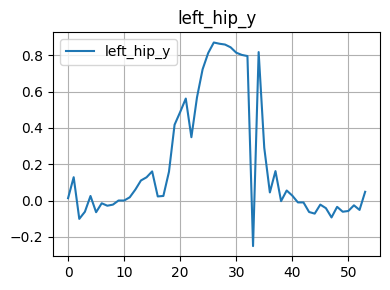

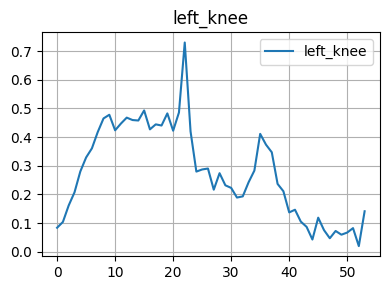

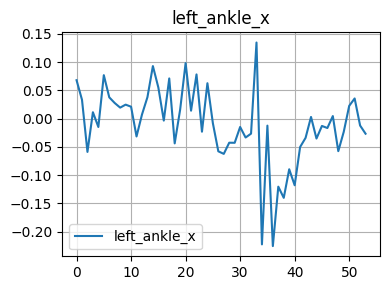

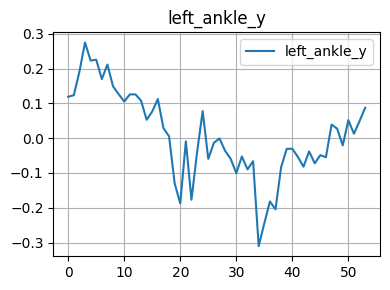

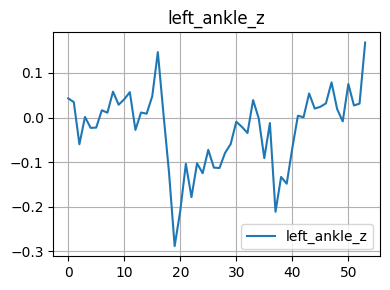

In [25]:
# visualize the actions, in range [-1,1]
time = np.arange(act_list.shape[0])
for i in range(act_list.shape[1]):
    link_name = components[i]
    link_act = act_list[:,i]
    plt.figure(figsize=(4, 3))
    plt.plot(time, link_act, label=link_name)
    plt.title(link_name)
    plt.legend() 
    plt.grid(True)
    plt.tight_layout()  